# Using a recurrent neural network LSTM to predict stock prices of companies

In [1]:
# required libraries
import math
import pandas_datareader as web
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


## Next we will need to get the stock quote

In [2]:
# using datareader as an interface for the raw api's for finance data
df = web.DataReader('AAPL', data_source='yahoo', start="2012-01-01", end="2019-12-17")
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,51.115936
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.390648
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.961189
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.504375
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.421093
...,...,...,...,...,...,...
2019-12-11,271.100006,268.500000,268.809998,270.769989,19689200.0,270.769989
2019-12-12,272.559998,267.320007,267.779999,271.459991,34327600.0,271.459991
2019-12-13,275.299988,270.929993,271.459991,275.149994,33396900.0,275.149994


In [3]:
# note that shape is (x,y) or (rows, columns)
df.shape

(2003, 6)

## Next up, visualise the data to see what the trends are like

/Users/stewart/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


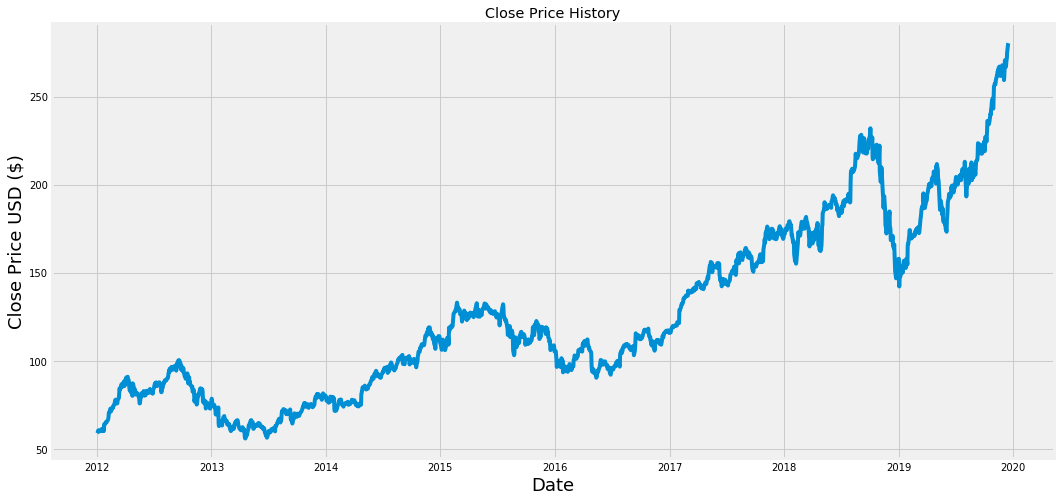

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# Now we will narrow down on just the close prices

In [5]:
# creates a new dataframe with just the closing prices
dataCloses = df.filter(["Close"])
# convert the dataframe to a numpy array
closes = dataCloses.values
# get the number of rows to train the model on (80%, 20% split)
training_data_len = math.ceil( len(closes) * 0.8)

training_data_len

1603

# Now scale the data between (0,1) to feed into a neural network

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaledCloses = scaler.fit_transform(closes)
scaledCloses

array([[0.01316509],
       [0.01457064],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

# Split the dataset into training and test

In [7]:
trainCloses = scaledCloses[0:training_data_len , :]
trainCloses
trainCloses_x = []
trainCloses_y = []
trainCloses.shape

(1603, 1)

## Note that here we will be creating windows of previous 60 days to train the model, but that can be adjusted below in "prevDaysTrain"

In [8]:
prevDaysTrain = 60
for i in range(prevDaysTrain, len(trainCloses)):
    # 60 day window previous
    trainCloses_x.append(trainCloses[i-prevDaysTrain:i, 0])
    # the next days price
    trainCloses_y.append(trainCloses[i,0])
print("trainCloses_x[60]",trainCloses_x[60],"\n To predict trainCloses_y[60]", trainCloses_y[60])
print("trainCloses_x[61]",trainCloses_x[61],"\n To predict trainCloses_y[61]", trainCloses_y[61])

trainCloses_x[60] [0.13949272 0.13293563 0.14507041 0.15186917 0.14868284 0.15464211
 0.1562639  0.15130952 0.14988489 0.14770341 0.13654806 0.12058461
 0.13939096 0.13852602 0.12523371 0.11603724 0.11522315 0.10796011
 0.13958178 0.13811897 0.13512982 0.12303317 0.1218566  0.12430516
 0.12165943 0.111121   0.11381126 0.11298446 0.11362047 0.11447267
 0.11204956 0.10664995 0.10343818 0.09892898 0.08877851 0.08894386
 0.10859608 0.10585498 0.11449811 0.11116553 0.10923845 0.11558567
 0.11997404 0.11905823 0.10841165 0.11051043 0.10958191 0.11507054
 0.11523589 0.12070543 0.11488607 0.1180597  0.11551573 0.11511504
 0.11676863 0.12417796 0.12521466 0.12415252 0.11902005 0.12183751] 
 To predict trainCloses_y[60] 0.11463170237902803
trainCloses_x[61] [0.13293563 0.14507041 0.15186917 0.14868284 0.15464211 0.1562639
 0.15130952 0.14988489 0.14770341 0.13654806 0.12058461 0.13939096
 0.13852602 0.12523371 0.11603724 0.11522315 0.10796011 0.13958178
 0.13811897 0.13512982 0.12303317 0.121856

# Now we've made training sets, we need to reshape the data into np arrays to feed into LSTM

In [9]:
# convert to numpy arrays
trainCloses_x, trainCloses_y = np.array(trainCloses_x), np.array(trainCloses_y)
# reshape the data
trainCloses_x = np.reshape(trainCloses_x, (trainCloses_x.shape[0], trainCloses_x.shape[1],1))
print("trainCloses_y.shape: ", trainCloses_y.shape)
print("trainClose_x.shape: ", trainCloses_x.shape)
print("trainCloses_x", trainCloses_x, "\n")
print("trainCloses_y", trainCloses_y, "\n")

trainCloses_y.shape:  (1543,)
trainClose_x.shape:  (1543, 60, 1)
trainCloses_x [[[0.01316509]
  [0.01457064]
  [0.01748985]
  ...
  [0.13766105]
  [0.14243103]
  [0.14442805]]

 [[0.01457064]
  [0.01748985]
  [0.02026915]
  ...
  [0.14243103]
  [0.14442805]
  [0.13949272]]

 [[0.01748985]
  [0.02026915]
  [0.01984303]
  ...
  [0.14442805]
  [0.13949272]
  [0.13293563]]

 ...

 [[0.52177011]
  [0.51927696]
  [0.51669488]
  ...
  [0.5857448 ]
  [0.59767603]
  [0.5912207 ]]

 [[0.51927696]
  [0.51669488]
  [0.51322235]
  ...
  [0.59767603]
  [0.5912207 ]
  [0.58926183]]

 [[0.51669488]
  [0.51322235]
  [0.51958863]
  ...
  [0.5912207 ]
  [0.58926183]
  [0.58164901]]] 

trainCloses_y [0.13949272 0.13293563 0.14507041 ... 0.58926183 0.58164901 0.58939538] 



# The LSTM model

In [10]:
# Build
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape= (trainCloses_x.shape[1], 1)))
model.add(LSTM(units=50, return_sequences= False))
model.add(Dense(units = 25))
model.add(Dense(units = 1))

In [11]:
# compile, or instatiate the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# train the model
model.fit(trainCloses_x, trainCloses_y, batch_size=1, epochs=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





1543/1543 [==============================] - 366s 237ms/step - loss: 7.1967e-04


# Create the test dataset (almost there!!)

In [13]:
# create the testing data set
testCloses = closes[training_data_len - prevDaysTrain: , :]
testCloses_x = []
testCloses_y = closes[training_data_len:,:]
for i in range(prevDaysTrain, len(testCloses)):
    testCloses_x.append(testCloses[i-prevDaysTrain: i , 0])

In [14]:
# convert to numpy array
testCloses_x = np.array(testCloses_x)
# reshape
testCloses_x = np.reshape(testCloses_x,(testCloses_x.shape[0], testCloses_x.shape[1], 1))
testCloses_x.shape
print(testCloses_x, "\n")
print(testCloses_y)

[[[171.07000732]
  [172.5       ]
  [175.5       ]
  ...
  [188.1499939 ]
  [186.44000244]
  [188.17999268]]

 [[172.5       ]
  [175.5       ]
  [178.97000122]
  ...
  [186.44000244]
  [188.17999268]
  [186.99000549]]

 [[175.5       ]
  [178.97000122]
  [178.38999939]
  ...
  [188.17999268]
  [186.99000549]
  [186.30999756]]

 ...

 [[220.96000671]
  [217.72999573]
  [218.72000122]
  ...
  [268.48001099]
  [270.76998901]
  [271.45999146]]

 [[217.72999573]
  [218.72000122]
  [217.67999268]
  ...
  [270.76998901]
  [271.45999146]
  [275.1499939 ]]

 [[218.72000122]
  [217.67999268]
  [221.02999878]
  ...
  [271.45999146]
  [275.1499939 ]
  [279.85998535]]] 

[[186.99000549]
 [186.30999756]
 [187.63000488]
 [187.16000366]
 [188.36000061]
 [188.1499939 ]
 [188.58000183]
 [187.8999939 ]
 [187.5       ]
 [186.86999512]
 [190.24000549]
 [191.83000183]
 [193.30999756]
 [193.97999573]
 [193.46000671]
 [191.69999695]
 [191.22999573]
 [192.27999878]
 [190.69999695]
 [190.80000305]
 [188.839996

# Predict on the test data, and convert from scaled to original price scales (using scaler object from previously)

In [19]:
closePreds = model.predict(testCloses_x)
print("preds1",closePreds)
closePreds = scaler.inverse_transform(closePreds)
print("preds2",closePreds)

preds1 [[1.8799416]
 [1.8799354]
 [1.87989  ]
 [1.8799258]
 [1.8799585]
 [1.8800613]
 [1.8801197]
 [1.8802012]
 [1.8801752]
 [1.880128 ]
 [1.8800706]
 [1.8803723]
 [1.8808206]
 [1.8812987]
 [1.881694 ]
 [1.8818752]
 [1.8817506]
 [1.8815824]
 [1.8816049]
 [1.8814408]
 [1.8813219]
 [1.8810091]
 [1.880769 ]
 [1.8804246]
 [1.8802086]
 [1.8800653]
 [1.8799437]
 [1.8797557]
 [1.87971  ]
 [1.8797259]
 [1.8797771]
 [1.8798037]
 [1.8798887]
 [1.8798218]
 [1.8797852]
 [1.8799224]
 [1.8803575]
 [1.8806204]
 [1.880454 ]
 [1.8806955]
 [1.880946 ]
 [1.8810476]
 [1.8811694]
 [1.8811233]
 [1.8812612]
 [1.8813199]
 [1.8813666]
 [1.8815728]
 [1.8819531]
 [1.8821374]
 [1.8818277]
 [1.8814452]
 [1.8812448]
 [1.8825499]
 [1.8842944]
 [1.8855022]
 [1.8863693]
 [1.8866537]
 [1.8868085]
 [1.8871115]
 [1.8871418]
 [1.8873061]
 [1.8875366]
 [1.8877476]
 [1.8882759]
 [1.8891875]
 [1.8895181]
 [1.8896302]
 [1.8896939]
 [1.889788 ]
 [1.8899354]
 [1.890262 ]
 [1.8907096]
 [1.8914267]
 [1.8921665]
 [1.8929752]
 [1.8

# Develop accuracies and plots to test predicitions

In [16]:
rmse = np.sqrt(np.mean((closePreds - testCloses_y)**2))
rmse

277.7958118476662

In [17]:
# split the original pandas dataframe into train and test
train = dataCloses[:training_data_len]
test = dataCloses[training_data_len:]
# add the predicitions to the test dataframe
test["Predictions"] = closePreds

/Users/stewart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


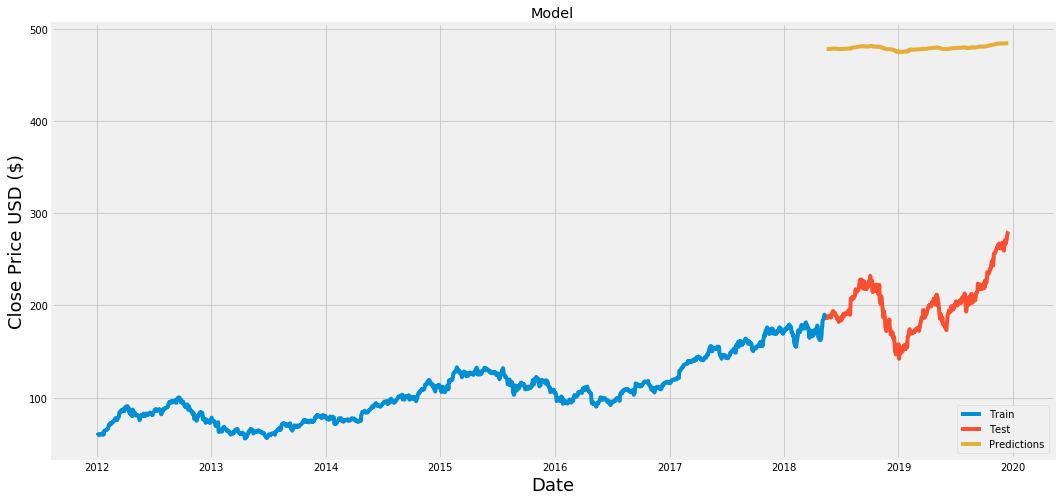

In [18]:
# visualize the data with mpl
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()